## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [2]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [76]:
ds = argo_loader.region([30,40,-55,-50, 200,2000]).to_xarray()

In [319]:
ds=ds.argo.point2profile()

In [485]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds_prof.PRES.where(ds_prof.PRES<depth_max).where(ds_prof.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds_prof.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [486]:
CT_interp=get_ds_interp(ds,200,2000,3)

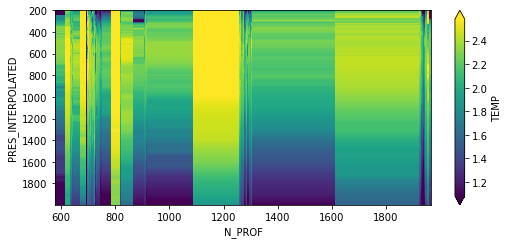

In [487]:
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [510]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [511]:
CT_filt=get_ds_filt(CT_interp,1,2,20)

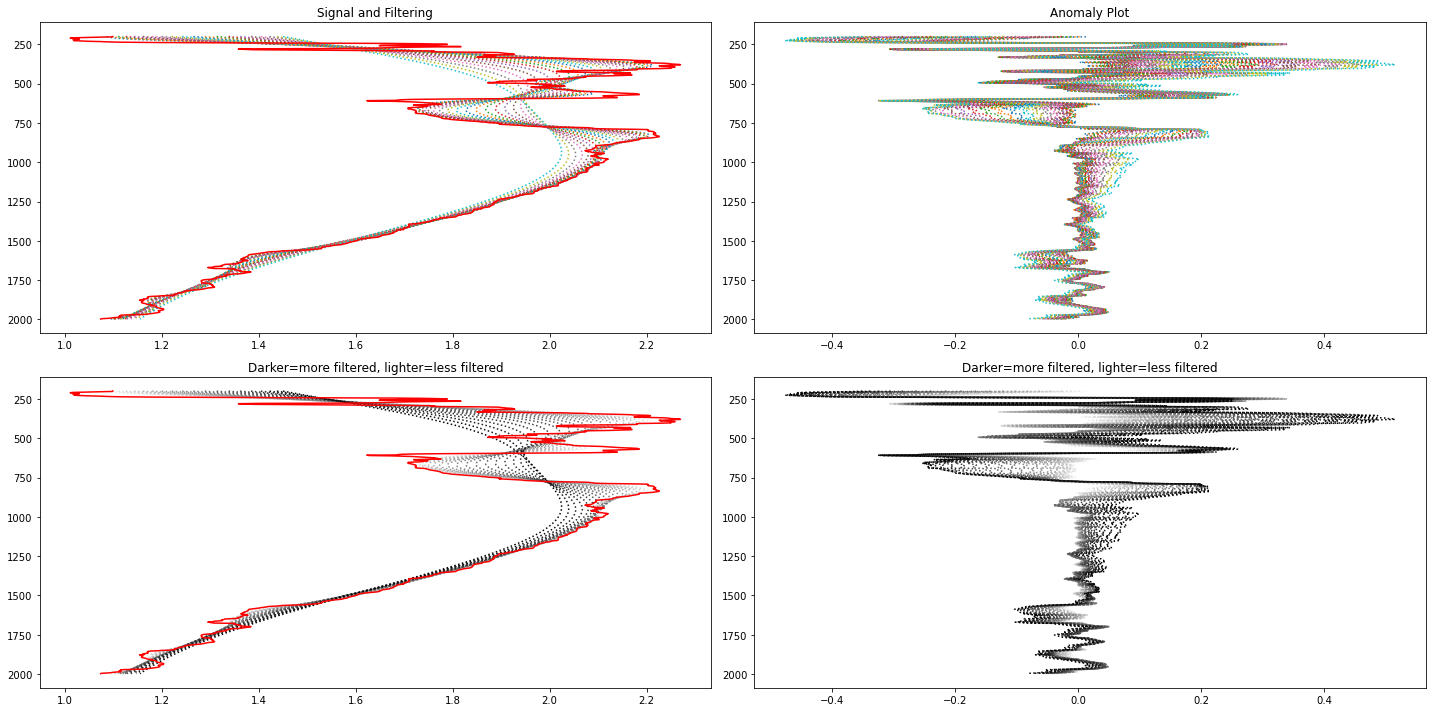

In [513]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/len(CT_filt.FILT_SCALE))
color=np.flip(color,0)
prof_num=CT_filt.N_PROF[50]
prof=CT_interp.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.gca().invert_yaxis()
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

#n regulates color only\
#sigma regulates FILT_SCALE

for n,sig in enumerate(CT_filt.FILT_SCALE):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sig)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

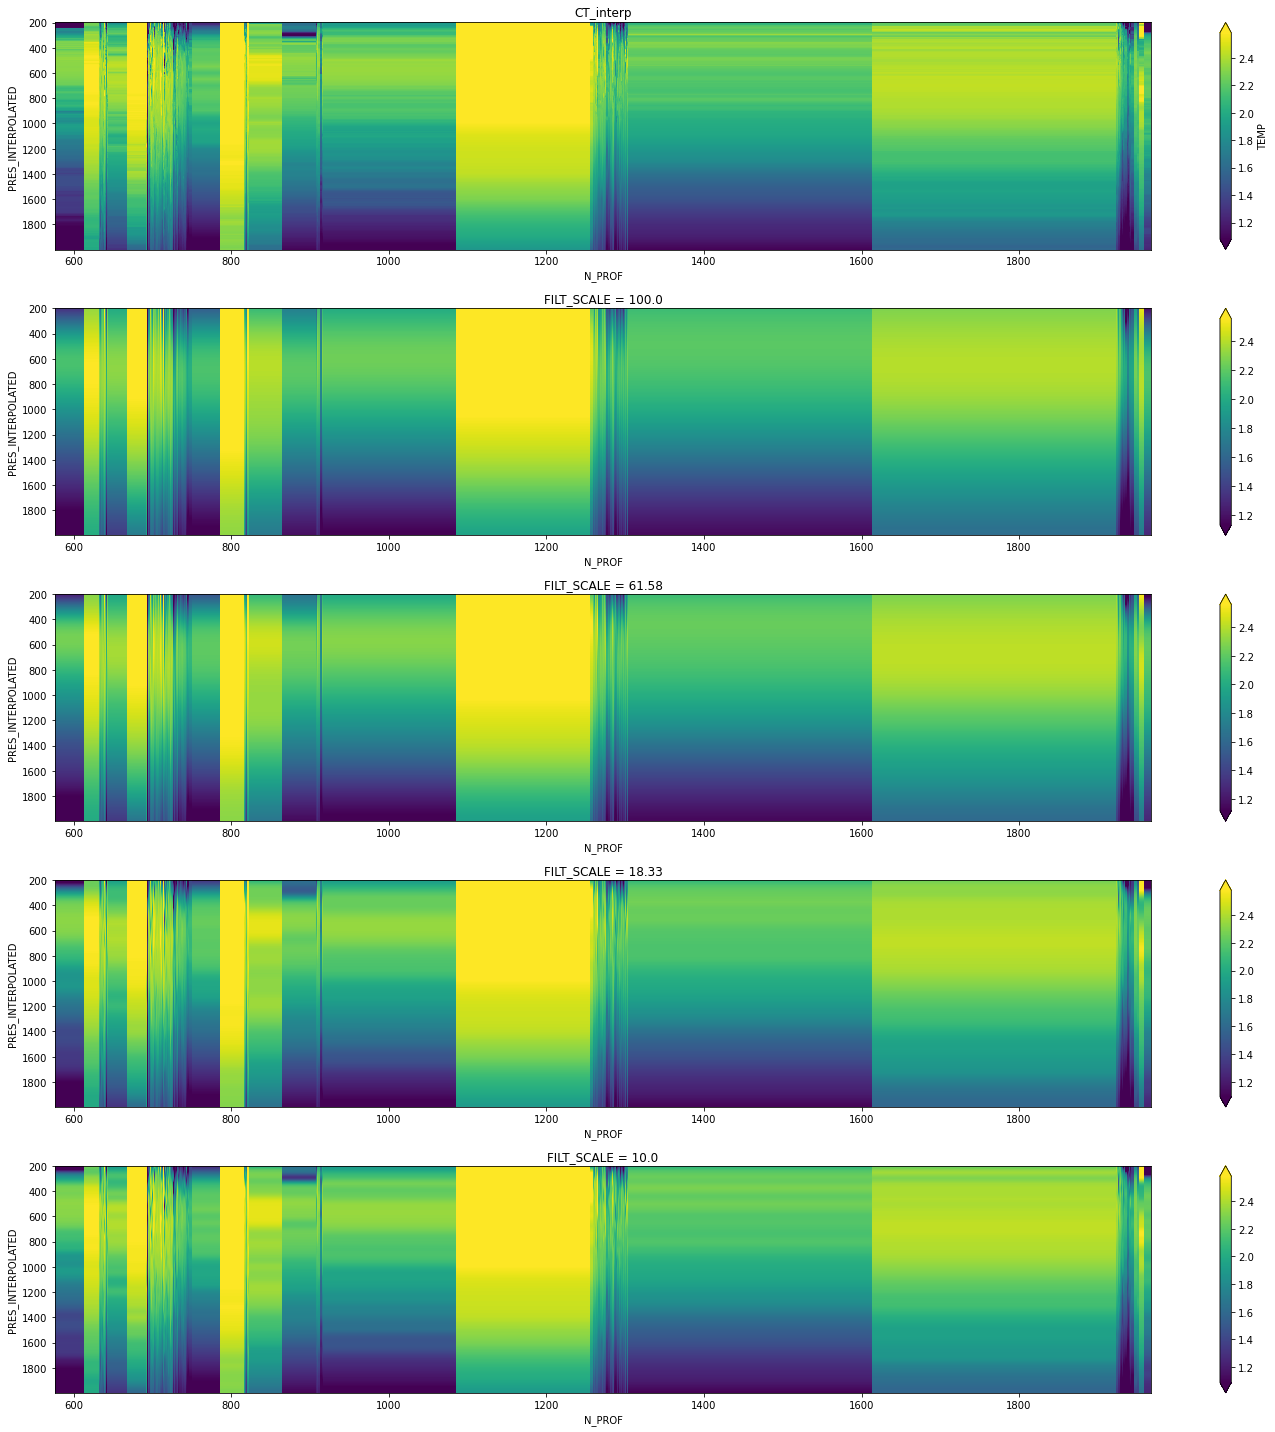

In [514]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("CT_interp")
plt.gca().invert_yaxis()

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-5],CT_filt.FILT_SCALE[5],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

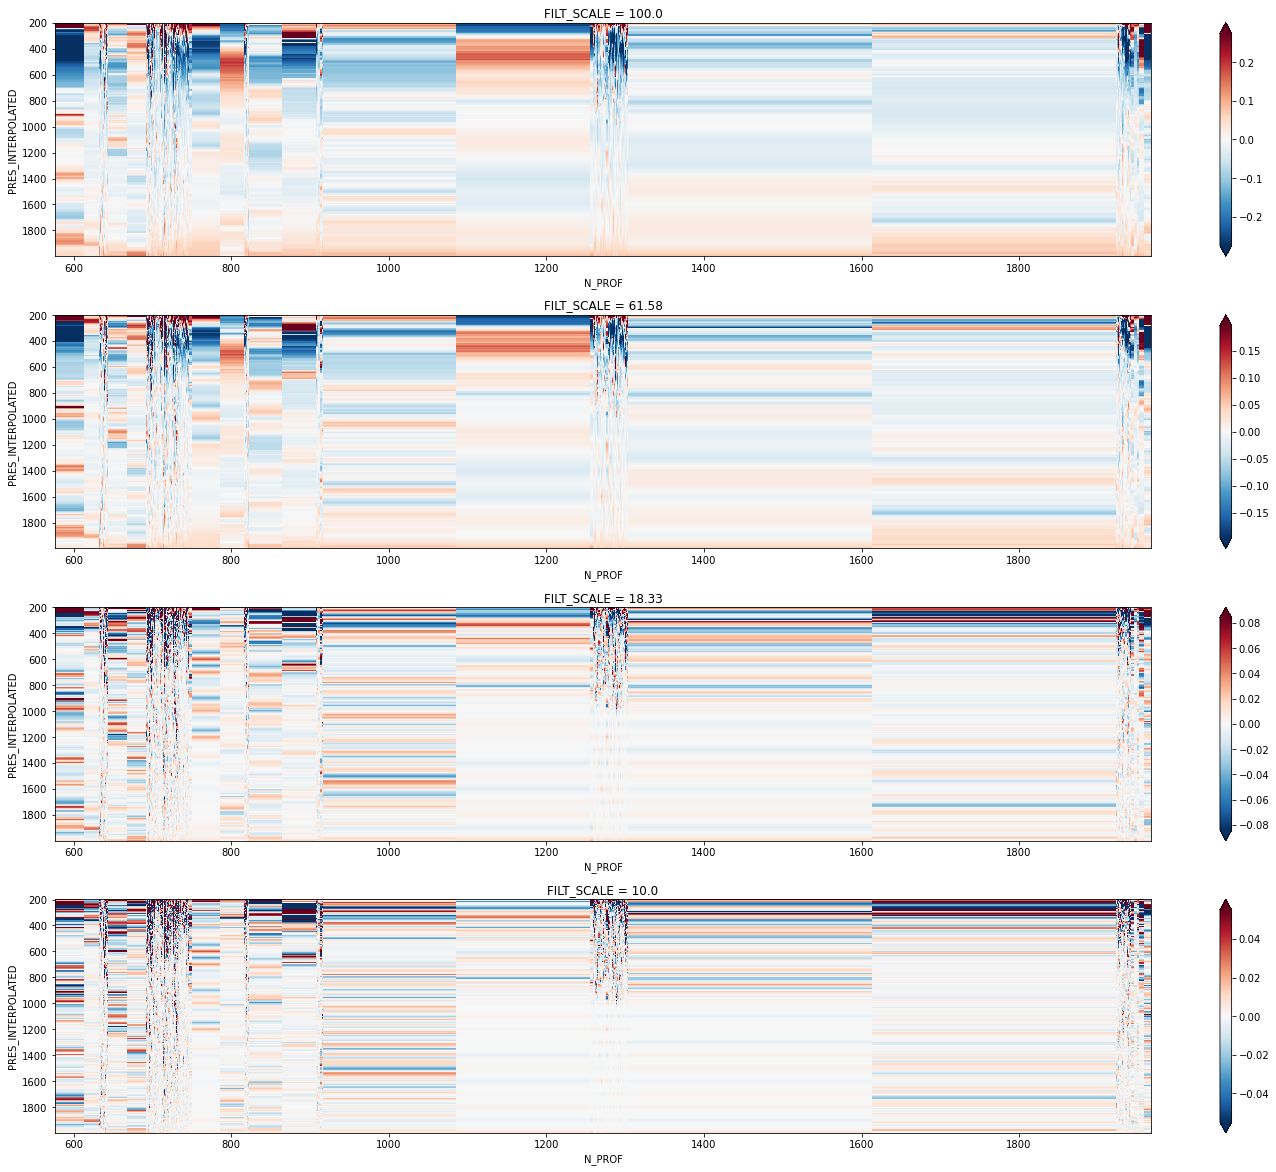

In [515]:
plt.figure(figsize=(20,20))

scales=(CT_filt.FILT_SCALE[-1],CT_filt.FILT_SCALE[-5],CT_filt.FILT_SCALE[5],CT_filt.FILT_SCALE[0])
for n,sig in enumerate(scales):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT_interp
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [516]:
var_scale=np.zeros(len(CT_filt.FILT_SCALE))

for n,sig in enumerate(CT_filt.FILT_SCALE):
    prof=CT_filt.sel(FILT_SCALE=sig)
    var_scale[n]=(prof-CT_interp).var()

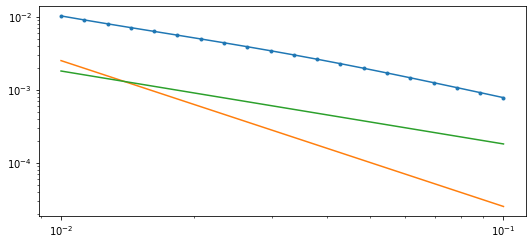

In [520]:
plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

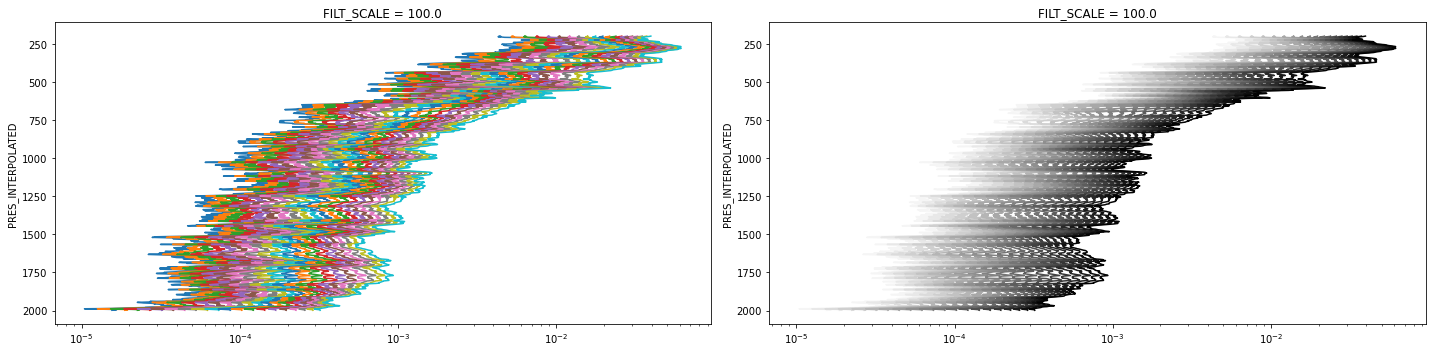

In [522]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(CT_filt.FILT_SCALE):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig,color=str(color[n]))

In [523]:
interp_1000_3=get_ds_interp(ds,0,1000,3)
interp_2000_3=get_ds_interp(ds,1000,2000,3)
interp_1000_12=get_ds_interp(ds,0,1000,12)
interp_2000_12=get_ds_interp(ds,1000,2000,12)

In [524]:
filt_1000_3=get_ds_filt(interp_1000_3,1,2,50)
filt_2000_3=get_ds_filt(interp_2000_3,1,2,50)
filt_1000_12=get_ds_filt(interp_1000_12,1,2,50)
filt_2000_12=get_ds_filt(interp_2000_12,1,2,50)

In [528]:
filt_1000_3

<xarray.DataArray (N_PROF: 405, PRES_INTERPOLATED: 500, FILT_SCALE: 50)>
array([[[2.92700005, 2.92700005, 2.92700005, ..., 2.92613626,
         2.92483568, 2.92332172],
        [2.92700005, 2.92700005, 2.92700005, ..., 2.92604923,
         2.92472219, 2.92318153],
        [2.92700005, 2.92700005, 2.92700005, ..., 2.92595911,
         2.92460513, 2.92303801],
        ...,
        [2.50963449, 2.50993752, 2.5102458 , ..., 2.54557323,
         2.54704189, 2.5485239 ],
        [2.50842404, 2.50875163, 2.50908518, ..., 2.54498363,
         2.54646516, 2.54795957],
        [2.5072825 , 2.50763011, 2.50798345, ..., 2.54439783,
         2.54589176, 2.54739857]],

       [[0.76200002, 0.76200002, 0.76200002, ..., 0.87985563,
         0.8944425 , 0.90964592],
        [0.76200002, 0.76200002, 0.76200002, ..., 0.88225842,
         0.89694744, 0.91223794],
        [0.76200002, 0.76200002, 0.76200002, ..., 0.88469803,
         0.89948744, 0.91486305],
...
        [2.18838024, 2.18857837, 2.18878078, ..., 2.21177816,
         2.21137094, 2.2107687 ],
        [2.18694305, 2.18718958, 2.18743825, ..., 2.21142602,
         2.21105289, 2.2104857 ],
        [2.18555808, 2.18584847, 2.18613958, ..., 2.21107292,
         2.21073365, 2.21020126]],

       [[1.50600004, 1.50600004, 1.50600004, ..., 1.58066189,
         1.58883739, 1.59726262],
        [1.50600004, 1.50600004, 1.50600004, ..., 1.58211565,
         1.59033561, 1.59879649],
        [1.50600004, 1.50600004, 1.50600004, ..., 1.58359015,
         1.59185326, 1.60034859],
        ...,
        [2.21735787, 2.21752381, 2.21770597, ..., 2.23800564,
         2.23844719, 2.23887372],
        [2.21689391, 2.21705627, 2.21723366, ..., 2.23772645,
         2.23817801, 2.2386148 ],
        [2.21646285, 2.2166214 , 2.21679425, ..., 2.23744822,
         2.23790979, 2.23835683]]])
Coordinates:
  * N_PROF             (N_PROF) int64 592 594 595 596 ... 2079 2080 2081 2082
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 8 ... 992 994 996 998
  * FILT_SCALE         (FILT_SCALE) float64 10.0 10.48 10.99 ... 95.41 100.0

In [529]:
var_1000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_3=np.zeros(len(filt_1000_3.FILT_SCALE))
var_1000_12=np.zeros(len(filt_1000_3.FILT_SCALE))
var_2000_12=np.zeros(len(filt_1000_3.FILT_SCALE))

for n,sig in enumerate(filt_1000_3.FILT_SCALE):
    prof_1000_3=filt_1000_3.sel(FILT_SCALE=sig,method='nearest')
    var_1000_3[n]=(prof_1000_3-interp_1000_3).var()
    
    prof_2000_3=filt_2000_3.sel(FILT_SCALE=sig,method='nearest')
    var_2000_3[n]=(prof_2000_3-interp_2000_3).var()
    
    prof_1000_12=filt_1000_12.sel(FILT_SCALE=sig,method='nearest')
    var_1000_12[n]=(prof_1000_12-interp_1000_12).var()
    
    prof_2000_12=filt_2000_12.sel(FILT_SCALE=sig,method='nearest')
    var_2000_12[n]=(prof_2000_12-interp_2000_12).var()

Text(0.5, 1.0, 'depth: [1000,2000]')

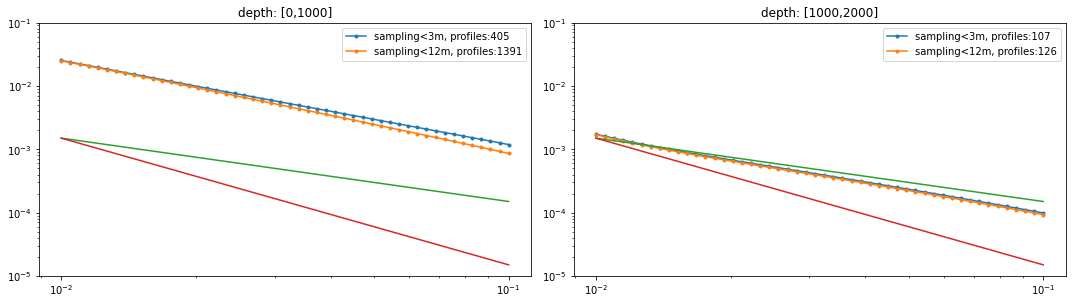

In [530]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(1/filt_1000_3.FILT_SCALE,var_1000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_1000_3.N_PROF.shape[0]))
plt.plot(1/filt_1000_12.FILT_SCALE,var_1000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_1000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.legend()
plt.ylim(10**-5,10**-1)
plt.title("depth: [0,1000]")

plt.subplot(2,2,2)
plt.plot(1/filt_2000_3.FILT_SCALE,var_2000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_2000_3.N_PROF.shape[0]))
plt.plot(1/filt_2000_12.FILT_SCALE,var_2000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_2000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.legend()
plt.ylim(10**-5,10**-1)
plt.title("depth: [1000,2000]")